In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Read in 
df11 = pd.read_csv('../data/df11.csv')

In [3]:
# Inspect
df11

,day,x1,x2,y
0,1,6.267497,C,4.603924
1,1,6.592165,C,2.319000
2,1,7.461689,A,14.341126
3,1,7.548916,A,14.588287
4,1,8.313763,B,5.284077
...,...,...,...,...
9995,60,16.125031,C,14.914215
9996,60,16.477850,C,5.508371
9997,60,16.824277,C,10.717834
9998,60,17.722692,C,9.113135


# Create a class that handles model rebuilding and predicting

Build such that we can vary certain parameters for testing:

- The number of previous days to use for fitting a model
    - Here, we will test a few different lookbacks to see how that affects predictions
- A function that fits the model
    - Here, we will only vary weights (e.g. to "upweight" more recent observations) but could pretty easily extend this to other model frameworks
- What prediction to return in the case of a model error
    - Here, we will assume that simply returning a static value is fine but in reality we might want to be a bit more data-driven

In [4]:
class BobTheBuilder(object):
    def __init__(
        self,
        n_days,
        model_fn,
        error_pred
    ):
        '''
        n_days:
            The number of previous days to use for fitting a model.
            Bob will start building on day n_days+1
        model_fn:
            A function that returns a fitted model object
            Function should take one argument: The data frame to use for building the model.
        error_pred:
            A static value to return if a model errors out
        '''
        self.n_days = n_days
        self.model_fn = model_fn
        self.error_pred = error_pred
        # We will save each model in a dictionary for easy referencing later, of the form {day: model}
        self.models = dict()
    
    def fit(self):
        '''
        For each day in between n_days+1 and 60, build a model that uses data from n_days before that day to create
        that day's predictions.  I.e. model "20" uses data from days 10-19 to predict day 20.
        '''
        for d in range(self.n_days+1, 60+1):
            
            # Get days to use for fitting the model
            days_to_include = [d - x for x in range(1, self.n_days+1)]
            print(f'Fitting day {d} using {len(days_to_include)} days: {days_to_include}')
            
            # Subset data and fit model
            df_sub = df11[df11.day.isin(days_to_include)]
            fit_model = self.model_fn(df_sub)            
            
            # Save model
            self.models[d] = fit_model
            
    def predict(self):
        '''
        Generate the predictions using the appropriate model (i.e. for day d, use self.models[d]).
        Brute forcing the implementation, there are better ways to implement something like this.
        '''
        pred = []
        for index, row in df11.iterrows():
            # If day is before n_days+1, return None
            if row.day <= 10:
                pred.append(None)
            else:
                try:
                    pred.append(
                        float(self.models[row.day].predict(df11[df11.index == index]))
                    )
                # If any error, return error_pred
                except:
                    pred.append(self.error_pred)
                
        return pred

Let's start simple:

- `n_days`: 10
- `model_fn`: A simple glm fitter
- `error_pred`: Simply return 0

In [5]:
def fitter_glm(df):
    return smf.ols(
        formula='y ~ x1 + x2',
        data=df
    ).fit()

btb_10_glm_0 = BobTheBuilder(
    n_days=10,
    model_fn=fitter_glm,
    error_pred=0
)
btb_10_glm_0.fit()

Fitting day 11 using 10 days: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Fitting day 12 using 10 days: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Fitting day 13 using 10 days: [12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
Fitting day 14 using 10 days: [13, 12, 11, 10, 9, 8, 7, 6, 5, 4]
Fitting day 15 using 10 days: [14, 13, 12, 11, 10, 9, 8, 7, 6, 5]
Fitting day 16 using 10 days: [15, 14, 13, 12, 11, 10, 9, 8, 7, 6]
Fitting day 17 using 10 days: [16, 15, 14, 13, 12, 11, 10, 9, 8, 7]
Fitting day 18 using 10 days: [17, 16, 15, 14, 13, 12, 11, 10, 9, 8]
Fitting day 19 using 10 days: [18, 17, 16, 15, 14, 13, 12, 11, 10, 9]
Fitting day 20 using 10 days: [19, 18, 17, 16, 15, 14, 13, 12, 11, 10]
Fitting day 21 using 10 days: [20, 19, 18, 17, 16, 15, 14, 13, 12, 11]
Fitting day 22 using 10 days: [21, 20, 19, 18, 17, 16, 15, 14, 13, 12]
Fitting day 23 using 10 days: [22, 21, 20, 19, 18, 17, 16, 15, 14, 13]
Fitting day 24 using 10 days: [23, 22, 21, 20, 19, 18, 17, 16, 15, 14]
Fitting day 25 using 10 days: [24, 23, 22, 21, 20, 

### Let's see how the coefficients change over time!

In [6]:
# Create a df with the coefficients
btb_10_glm_0_coeffs = pd.DataFrame([btb_10_glm_0.models[x].params for x in btb_10_glm_0.models.keys()])
btb_10_glm_0_coeffs['day'] = [x for x in range(11, 61)]

# Melt
btb_10_glm_0_coeffs = pd.melt(
    btb_10_glm_0_coeffs,
    id_vars=['day']
)

# Inspect
btb_10_glm_0_coeffs

,day,variable,value
0,11,Intercept,10.373123
1,12,Intercept,10.235700
2,13,Intercept,10.081464
3,14,Intercept,10.240351
4,15,Intercept,10.180810
...,...,...,...
245,56,x2[T.D],-14.924156
246,57,x2[T.D],-15.029893
247,58,x2[T.D],-15.067916
248,59,x2[T.D],-14.994284


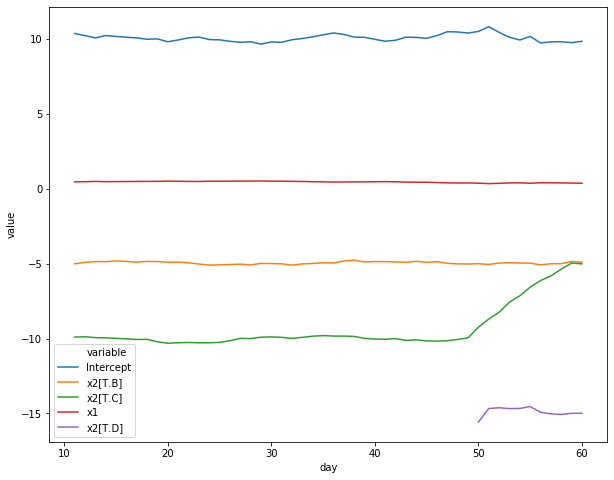

In [7]:
# Plot
plt.figure(figsize=(10, 8))
sb.lineplot(data=btb_10_glm_0_coeffs, x='day', y='value', hue='variable')
plt.legend(loc='lower left')

### Plot AMSE over time

In [8]:
# Helper functions
def mse(actual, pred):
    err = pred - actual
    return err ** 2

def amse(mse):
    return np.sum(mse) / len(mse)

def amse_by_day(df, p):
    # Get predictions
    df = df.assign(p = df[p])
    
    # Get MSE
    df['mse'] = df.apply(lambda x: mse(x.y, x.p), axis=1)
    
    # Aggregate
    df_agg = (
        df
        .groupby('day')
        .agg(
            n=('day', 'count'),
            mse_total=('mse', 'sum'),
            amse=('mse', lambda x: amse(x)),
        )
        .reset_index()
        .sort_values('day')
    )
    
    return df_agg

In [9]:
# Get predictions
df11['btb_10_glm_0'] = btb_10_glm_0.predict()

# Inspect
df11

,day,x1,x2,y,btb_10_glm_0
0,1,6.267497,C,4.603924,NaN
1,1,6.592165,C,2.319000,NaN
2,1,7.461689,A,14.341126,NaN
3,1,7.548916,A,14.588287,NaN
4,1,8.313763,B,5.284077,NaN
...,...,...,...,...,...
9995,60,16.125031,C,14.914215,10.883620
9996,60,16.477850,C,5.508371,11.015781
9997,60,16.824277,C,10.717834,11.145548
9998,60,17.722692,C,9.113135,11.482082


<ipython-input-8-7313f777fea5>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


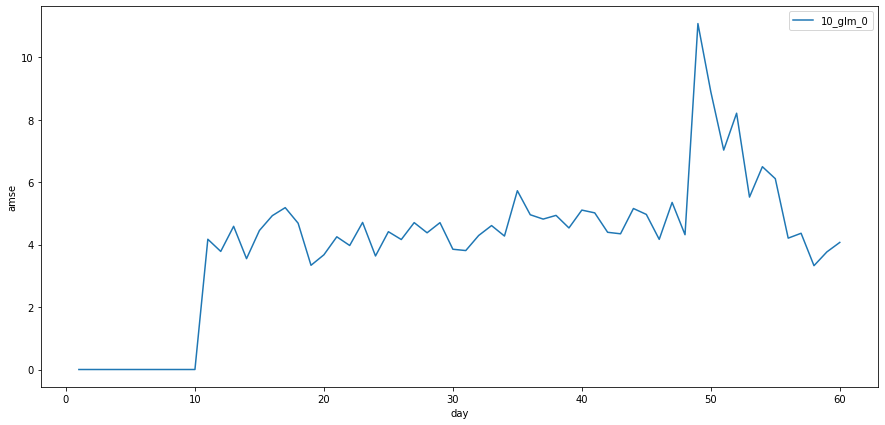

In [10]:
btb_10_glm_0_amse = amse_by_day(df11, 'btb_10_glm_0')

# Plot
plt.figure(figsize=(15, 7))
sb.lineplot(data=btb_10_glm_0_amse, x='day', y='amse', label='10_glm_0')

That seems to be doing a decent job of staying adjusted to our previously noted effect drift.  There is still a notable spike around day 50, probably when `x2 = D` is first seen.

Let's try a few other things to see how they affects the average errors:

- Different `n_days`
    - For simplicity, let's try both 1 and 5
- Better prediction when the model errors (0 isn't even in the range of y-values that we see in the data)
    - For simplicity, let's take the average y value in the original training data (i.e. days 1-10)

In [11]:
btb_5_glm_0 = BobTheBuilder(
    n_days=5,
    model_fn=fitter_glm,
    error_pred=0
)
btb_5_glm_0.fit()

Fitting day 6 using 5 days: [5, 4, 3, 2, 1]
Fitting day 7 using 5 days: [6, 5, 4, 3, 2]
Fitting day 8 using 5 days: [7, 6, 5, 4, 3]
Fitting day 9 using 5 days: [8, 7, 6, 5, 4]
Fitting day 10 using 5 days: [9, 8, 7, 6, 5]
Fitting day 11 using 5 days: [10, 9, 8, 7, 6]
Fitting day 12 using 5 days: [11, 10, 9, 8, 7]
Fitting day 13 using 5 days: [12, 11, 10, 9, 8]
Fitting day 14 using 5 days: [13, 12, 11, 10, 9]
Fitting day 15 using 5 days: [14, 13, 12, 11, 10]
Fitting day 16 using 5 days: [15, 14, 13, 12, 11]
Fitting day 17 using 5 days: [16, 15, 14, 13, 12]
Fitting day 18 using 5 days: [17, 16, 15, 14, 13]
Fitting day 19 using 5 days: [18, 17, 16, 15, 14]
Fitting day 20 using 5 days: [19, 18, 17, 16, 15]
Fitting day 21 using 5 days: [20, 19, 18, 17, 16]
Fitting day 22 using 5 days: [21, 20, 19, 18, 17]
Fitting day 23 using 5 days: [22, 21, 20, 19, 18]
Fitting day 24 using 5 days: [23, 22, 21, 20, 19]
Fitting day 25 using 5 days: [24, 23, 22, 21, 20]
Fitting day 26 using 5 days: [25, 24, 2

In [12]:
btb_1_glm_0 = BobTheBuilder(
    n_days=1,
    model_fn=fitter_glm,
    error_pred=0
)
btb_1_glm_0.fit()

Fitting day 2 using 1 days: [1]
Fitting day 3 using 1 days: [2]
Fitting day 4 using 1 days: [3]
Fitting day 5 using 1 days: [4]
Fitting day 6 using 1 days: [5]
Fitting day 7 using 1 days: [6]
Fitting day 8 using 1 days: [7]
Fitting day 9 using 1 days: [8]
Fitting day 10 using 1 days: [9]
Fitting day 11 using 1 days: [10]
Fitting day 12 using 1 days: [11]
Fitting day 13 using 1 days: [12]
Fitting day 14 using 1 days: [13]
Fitting day 15 using 1 days: [14]
Fitting day 16 using 1 days: [15]
Fitting day 17 using 1 days: [16]
Fitting day 18 using 1 days: [17]
Fitting day 19 using 1 days: [18]
Fitting day 20 using 1 days: [19]
Fitting day 21 using 1 days: [20]
Fitting day 22 using 1 days: [21]
Fitting day 23 using 1 days: [22]
Fitting day 24 using 1 days: [23]
Fitting day 25 using 1 days: [24]
Fitting day 26 using 1 days: [25]
Fitting day 27 using 1 days: [26]
Fitting day 28 using 1 days: [27]
Fitting day 29 using 1 days: [28]
Fitting day 30 using 1 days: [29]
Fitting day 31 using 1 days: [3

In [13]:
btb_10_glm_mean = BobTheBuilder(
    n_days=10,
    model_fn=fitter_glm,
    error_pred=df11[df11.day <= 10]['y'].mean()
)
btb_10_glm_mean.fit()

Fitting day 11 using 10 days: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Fitting day 12 using 10 days: [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
Fitting day 13 using 10 days: [12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
Fitting day 14 using 10 days: [13, 12, 11, 10, 9, 8, 7, 6, 5, 4]
Fitting day 15 using 10 days: [14, 13, 12, 11, 10, 9, 8, 7, 6, 5]
Fitting day 16 using 10 days: [15, 14, 13, 12, 11, 10, 9, 8, 7, 6]
Fitting day 17 using 10 days: [16, 15, 14, 13, 12, 11, 10, 9, 8, 7]
Fitting day 18 using 10 days: [17, 16, 15, 14, 13, 12, 11, 10, 9, 8]
Fitting day 19 using 10 days: [18, 17, 16, 15, 14, 13, 12, 11, 10, 9]
Fitting day 20 using 10 days: [19, 18, 17, 16, 15, 14, 13, 12, 11, 10]
Fitting day 21 using 10 days: [20, 19, 18, 17, 16, 15, 14, 13, 12, 11]
Fitting day 22 using 10 days: [21, 20, 19, 18, 17, 16, 15, 14, 13, 12]
Fitting day 23 using 10 days: [22, 21, 20, 19, 18, 17, 16, 15, 14, 13]
Fitting day 24 using 10 days: [23, 22, 21, 20, 19, 18, 17, 16, 15, 14]
Fitting day 25 using 10 days: [24, 23, 22, 21, 20, 

In [14]:
# Get predictions
df11['btb_5_glm_0'] = btb_5_glm_0.predict()
df11['btb_1_glm_0'] = btb_1_glm_0.predict()
df11['btb_10_glm_mean'] = btb_10_glm_mean.predict()

# Inspect
df11

,day,x1,x2,y,btb_10_glm_0,btb_5_glm_0,btb_1_glm_0,btb_10_glm_mean
0,1,6.267497,C,4.603924,NaN,NaN,NaN,NaN
1,1,6.592165,C,2.319000,NaN,NaN,NaN,NaN
2,1,7.461689,A,14.341126,NaN,NaN,NaN,NaN
3,1,7.548916,A,14.588287,NaN,NaN,NaN,NaN
4,1,8.313763,B,5.284077,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9995,60,16.125031,C,14.914215,10.883620,10.638229,10.234116,10.883620
9996,60,16.477850,C,5.508371,11.015781,10.761196,10.349682,11.015781
9997,60,16.824277,C,10.717834,11.145548,10.881936,10.463155,11.145548
9998,60,17.722692,C,9.113135,11.482082,11.195060,10.757430,11.482082


<ipython-input-8-7313f777fea5>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(mse) / len(mse)


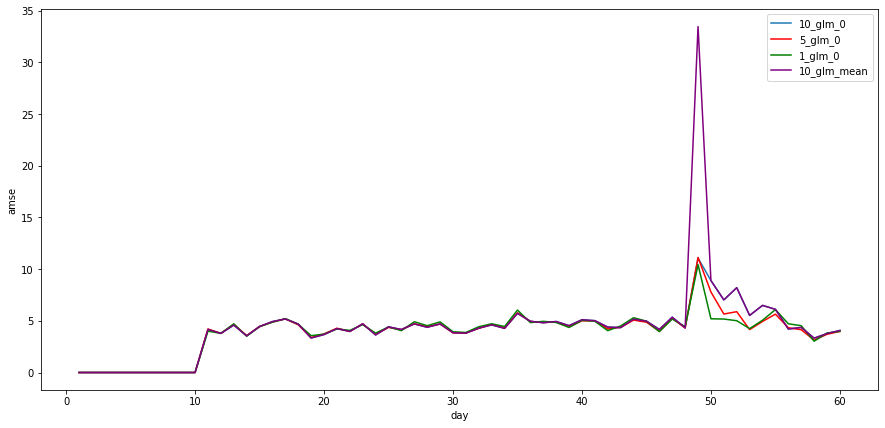

In [15]:
btb_5_glm_0_amse = amse_by_day(df11, 'btb_5_glm_0')
btb_1_glm_0_amse = amse_by_day(df11, 'btb_1_glm_0')
btb_10_glm_mean_amse = amse_by_day(df11, 'btb_10_glm_mean')

# Plot
plt.figure(figsize=(15, 7))
sb.lineplot(data=btb_10_glm_0_amse, x='day', y='amse', label='10_glm_0')
sb.lineplot(data=btb_5_glm_0_amse, x='day', y='amse', color='red', label='5_glm_0')
sb.lineplot(data=btb_1_glm_0_amse, x='day', y='amse', color='green', label='1_glm_0')
sb.lineplot(data=btb_10_glm_mean_amse, x='day', y='amse', color='purple', label='10_glm_mean')

The mean prediction seems to be doing much worse.  Probably because the effect of `x2 = D` has a net negative effect and we made it a more positive by changing from 0.

Let's remove that line and re-plot

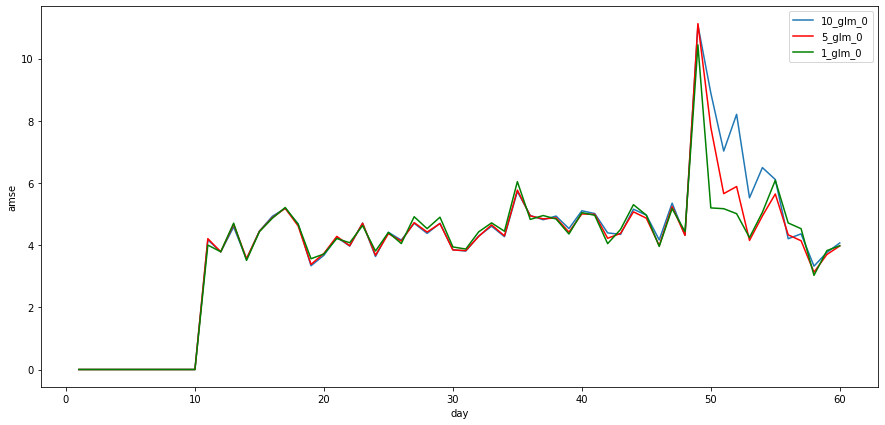

In [16]:
# Plot
plt.figure(figsize=(15, 7))
sb.lineplot(data=btb_10_glm_0_amse, x='day', y='amse', label='10_glm_0')
sb.lineplot(data=btb_5_glm_0_amse, x='day', y='amse', color='red', label='5_glm_0')
sb.lineplot(data=btb_1_glm_0_amse, x='day', y='amse', color='green', label='1_glm_0')

Notes:

- All of these are notably better over the spectrum of our data compared to our previous non-adaptive models
- For most days these models result in very similar predictions
    - Qualitatively, it looks like 1 previous day is a bit noisier in it's predictions and often has slightly worse performance (and especially on days before the spike)
- Using fewer previous days means we're able to better adjust the day after seeing `x2 = D`

I would probably choose `5_glm_0` out of these models here to balance stability of predictions with responsiveness to drift in our data over time.  

Some other things we could probably do to improve this:

- Define `error_pred` to depend on data from the previous days, which might help reduce the peak due to `x2 = D`
- Use a weighted regression where more recent observations are weighted higher than older observations (e.g. using a linear or quadratic scale where the most recent day has a weight of 1 and the least recent date used in the model has a weight near 0).